https://www.analyticsvidhya.com/blog/2021/06/k-means-clustering-and-transfer-learning-for-image-classification/

https://medium.com/@joel_34096/k-means-clustering-for-image-classification-a648f28bdc47

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from scipy.stats import mode

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import  KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

from time import time
import os
import pathlib
import shutil
from skimage import io
import cv2

In [2]:
# self-written scripts
import sys
sys.path.insert(0, 'Python_Scripts')

import util

In [3]:
# Loading the complete dataset (including class 0)
df = pd.read_csv('data/train_complete.csv')
df.head()

,FilePath,ImageId,ClassId,EncodedPixels,Defect
0,/Users/fabioteichmann/neuefische/projects/Caps...,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,/Users/fabioteichmann/neuefische/projects/Caps...,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1
2,/Users/fabioteichmann/neuefische/projects/Caps...,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1
3,/Users/fabioteichmann/neuefische/projects/Caps...,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,/Users/fabioteichmann/neuefische/projects/Caps...,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1


In [4]:
# Loading the train dataset without class 0
df2 = pd.read_csv('data/train.csv')
df2.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [5]:
util.isolate_single_defects(df2)

In [6]:
df2.sample(10)

,ImageId,ClassId,EncodedPixels
2673,62f84c877.jpg,3,20298 5 20546 15 20798 22 21054 25 21311 26 21...
3235,75f92b24f.jpg,3,180993 26 181249 76 181505 127 181761 177 1820...
5484,c5a65a795.jpg,3,298465 32 298657 96 298849 160 299041 35533 33...
5322,bfd38637f.jpg,4,335042 2 335296 4 335550 6 335804 9 336058 11 ...
3740,8847458a0.jpg,3,248384 193 248640 193 248896 193 249152 193 24...
2803,67ae369d2.jpg,3,4 20 260 40 354 24 411 4 516 40 610 24 661 12 ...
3063,7039151ef.jpg,3,316258 3 316302 5 316348 1 316452 9 316469 51 ...
1532,388e36308.jpg,3,49470 8 49727 21 49983 35 50240 42 50496 40 50...
2433,5aa1c319d.jpg,3,252638 35 252826 103 253014 171 253235 206 253...
1722,3fea4633e.jpg,4,103996 2 104250 6 104504 10 104758 14 105012 1...


In [7]:
# isolate only images that have 0 or 1 defect
util.isolate_single_defects(df)

In [8]:
# eliminate class 0 images in dataset
df = df.query('ClassId!=0')
df.shape

(6239, 5)

In [ ]:
# safe all images with single defects
path = pathlib.Path.cwd()
try:
    os.mkdir(path.joinpath('data','single_defect_train_images'))
except:
    print('Folder already exists.')
    # von Michael kopiert für Ordnererstellung basierend auf x_train
for i in range(len(df)):
    origin_train_path = path.joinpath('data', 'train_images')
    source_file = df.iloc[i,1]
    target_directory = path.joinpath('data', 'single_defect_train_images')
    shutil.copy2(origin_train_path.joinpath(source_file) , target_directory.joinpath(source_file))


In [ ]:
df.head()

### Preprozessing for single image (Example)

In [9]:
# load image (example)
images = io.imread('data/single_defect_train_images/0002cc93b.jpg')
print('Org image shape --> ',images.shape)

Org image shape -->  (256, 1600, 3)


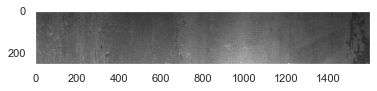

In [10]:
plt.rcParams['axes.grid'] = False
plt.imshow(images)

In [13]:
#resize images
IMG_SIZE = 32
image_resized=cv2.resize(images,(IMG_SIZE,IMG_SIZE))
print('After resizing shape --> ',image_resized.shape)

After resizing shape -->  (32, 32, 3)


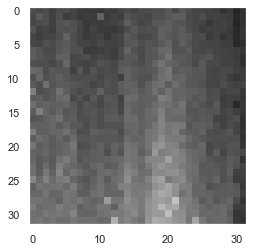

In [14]:
plt.rcParams['axes.grid'] = False
plt.imshow(image_resized)

In [16]:
#The input data have to be converted from 3 dimensional format to 1 dimensional format to be fed into the K-Means Clustering algorithm (Reshape images)
#image_flat = image_resized.reshape(len(image_resized),-1)
image_flat = image_resized.reshape(1, 3*IMG_SIZE*IMG_SIZE)

print('After Flattening shape --> ',image_flat.shape)

After Flattening shape -->  (1, 3072)


In [41]:
def get_prepared_images(df, image_size):
    
    image_ids = df.ImageId.to_list()
    image_list =[]
    prepared_images = pd.DataFrame()
    
    print('beginning to prepare images...')

    for image_id in image_ids:

        image = io.imread('data/augmentations/' + image_id)
        #resize images
        image_resized=cv2.resize(image, (image_size,image_size))
        #The input data have to be converted from 3 dimensional format to 1 dimensional format
        image_flat = image_resized.reshape(1, 3 * image_size * image_size)
        # Data Normalization
        # Conversion to float
        image_flat=image_flat.astype('float32')
        # Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
        image_flat = image_flat / 255.0
        
        temp = pd.DataFrame(image_flat)
        prepared_images = pd.concat([prepared_images, temp], axis=0)
        
        if len(prepared_images) % 100 == 0 and len(prepared_images) != 0:
            print(f'{len(prepared_images)} images processed...')
        
        # image_list.append([image_id, image_flat[0]])
    prepared_images.reset_index(drop=True, inplace=True)
    print('adding Ids to the images...')
    prepared_images = pd.concat([df.ImageId, prepared_images], axis=1)
    # split_flattened_images = split_flat_images(temp) pd.DataFrame(df_flat_img['flattened_images'].tolist())
    print('done!')
    return prepared_images

In [18]:
flattened_images =[]

IMG_SIZE = 128
for image_id in df['ImageId']:
    image = io.imread('data/single_defect_train_images/' + image_id)
    #resize images
    image_resized=cv2.resize(image,(IMG_SIZE,IMG_SIZE))
    #The input data have to be converted from 3 dimensional format to 1 dimensional format
    image_flat = image_resized.reshape(1, 3*IMG_SIZE*IMG_SIZE)
    # Data Normalization
    # Conversion to float
    image_flat=image_flat.astype('float32')
    # Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
    image_flat = image_flat/255.0
    flattened_images.append([image_id,image_flat[0]])

In [19]:
df_flat_img = pd.DataFrame(flattened_images , columns = ['ImageId', 'flattened_images'])
df_flat_img = pd.merge(df_flat_img, df[['ImageId','ClassId']], on='ImageId')


df_flat_img.head(2)

,ImageId,flattened_images,ClassId
0,0002cc93b.jpg,"[0.28627452, 0.28627452, 0.28627452, 0.2588235...",1
1,0007a71bf.jpg,"[0.19607843, 0.19607843, 0.19607843, 0.1882353...",3


In [24]:
#flattened_images.head(2)

In [22]:
split_flattened_images = pd.DataFrame(df_flat_img['flattened_images'].tolist())

In [23]:
df_flat_complete = pd.concat([df_flat_img, split_flattened_images], axis=1)
#flattened_images

In [25]:
df_flat_complete.head(2)

,ImageId,flattened_images,ClassId,0,1,2,3,4,5,6,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0002cc93b.jpg,"[0.28627452, 0.28627452, 0.28627452, 0.2588235...",1,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,...,0.207843,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216
1,0007a71bf.jpg,"[0.19607843, 0.19607843, 0.19607843, 0.1882353...",3,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,...,0.333333,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176


In [26]:
df_flat_complete.drop(['flattened_images'], axis=1, inplace=True)

In [27]:
df_flat_complete.head(2)

,ImageId,ClassId,0,1,2,3,4,5,6,7,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0002cc93b.jpg,1,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,0.266667,...,0.207843,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216
1,0007a71bf.jpg,3,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,0.184314,...,0.333333,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176


In [28]:
df_flat_complete_images_X=flattened_images.drop(['ImageId','flattened_images'], axis = 1)
flattened_images_X

AttributeError: 'list' object has no attribute 'drop'

In [29]:
flattened_images_X = split_flattened_images

In [30]:
flattened_images_X.head(2)

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,0.266667,0.266667,0.239216,...,0.207843,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216
1,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,0.200000,...,0.333333,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176


In [ ]:
# # Use TSNE before modeling
# tsne = TSNE(n_components=2, init='random', random_state=0)
# digits_proj = tsne.fit_transform(flattened_images_X)
# # Creating the KMeans model and predict classes (n_clusters =4 ; due to 4 classes)
# kmeans = KMeans(n_clusters=4, random_state=0)
# clusters = kmeans.fit_predict(digits_proj)
# kmeans.cluster_centers_.shape

---

### Create Clusters (K-Means)

In [31]:
# without TSNE
# Creating the KMeans model and predict classes (n_clusters =4 ; due to 4 classes)
n_clusters=12
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(flattened_images_X)
kmeans.cluster_centers_.shape

(12, 49152)

In [32]:
clusters.shape

(6239,)

In [33]:
def plot_cluster_centers(n_clusters, kmeans):
    # Plot the cluster centers
    fig, ax = plt.subplots(4, 3, figsize=(12, 10))
    centers = kmeans.cluster_centers_.reshape(n_clusters, 128, 384)
    for axi, center in zip(ax.flat, centers):
        #axi.set(xticks=[], yticks=[])
        axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

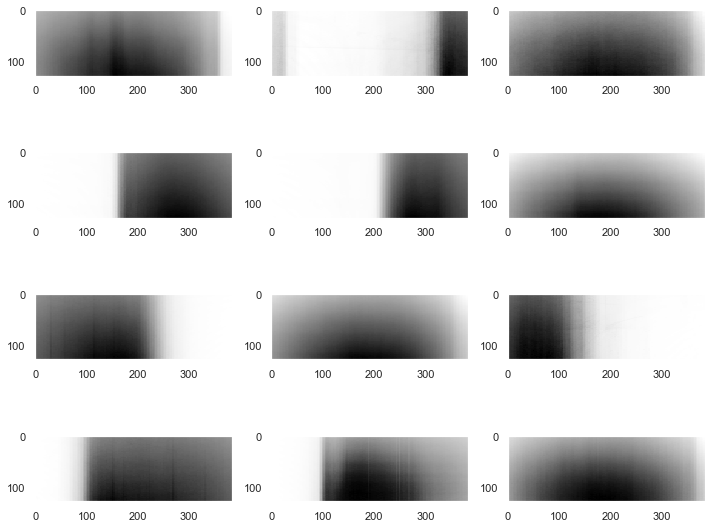

In [34]:
plot_cluster_centers(n_clusters, kmeans)

In [35]:
# Use TSNE before modeling
tsne = TSNE(n_components=2, init='random', random_state=0)
steel_projection = tsne.fit_transform(flattened_images_X)
steel_projection.shape

/Users/fabioteichmann/neuefische/projects/CapstoneProject_SteelDefectDetection/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(6239, 2)

In [36]:
def get_tsne_projection(data):
    tsne = TSNE(n_components=2, init='random', random_state=0)
    projection = tsne.fit_transform(data)
    projection.shape
    return projection

In [37]:
steel_projection = get_tsne_projection(flattened_images_X)

/Users/fabioteichmann/neuefische/projects/CapstoneProject_SteelDefectDetection/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [38]:
def get_colors(num_classes):
    color_spectrum = ["lightcoral","steelblue","mediumseagreen","khaki"]
    
    if num_classes <= len(color_spectrum):
        colors = color_spectrum[:num_classes]
        return colors
    else:
        print(f'`num_classes` is greater than {len(color_spectrum)}')

- [Matplotlib Colors](https://matplotlib.org/stable/gallery/color/named_colors.html)
- [Matplotlib Legends](https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html)

In [39]:
import matplotlib.colors as mc

def plot_tsne(projection, df):
    plt.figure(figsize=(10,10))
    num_classes = df.ClassId.nunique()
    colors = get_colors(num_classes)

    # Create a custom color map to represent our 4 different classes
    cmap = mc.LinearSegmentedColormap.from_list("", colors)

    scatter = plt.scatter(projection[:, 0], projection[:, 1], c=df.ClassId, cmap=cmap)
    plt.legend(*scatter.legend_elements(),loc='upper left');


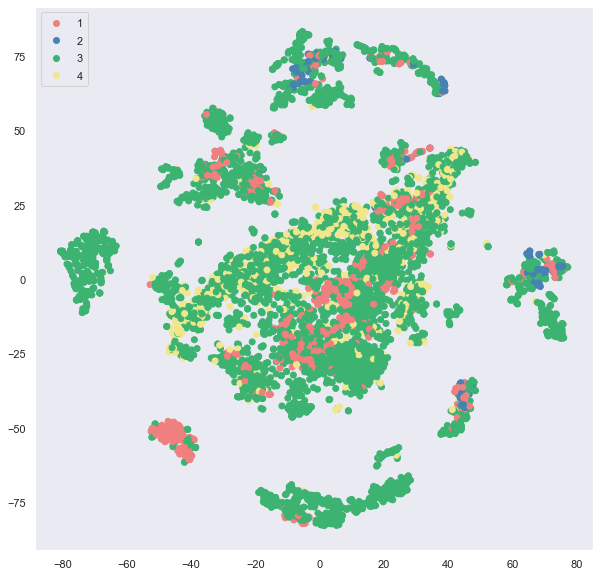

In [40]:
plot_tsne(steel_projection, df_flat_complete)

`t-SNE` does not seem to be able to split pictures well into clusters for our 4 `ClassIds`

#### without `ClassId` 3

In [ ]:
class_3 = df_flat_complete.query('ClassId != 3')
class_3_x = class_3.drop(['ImageId','ClassId'], axis=1)

In [ ]:
cl3_projection = get_tsne_projection(class_3_x)

In [ ]:
plot_tsne(cl3_projection, class_3)

---

#### Clustering with augmented pictures

In [ ]:
df_aug = pd.read_csv('data/train_single_defects_augmented.csv')
df_aug

In [ ]:
image_size=128

image = io.imread('data/augmentations/'+df_aug.ImageId[0])

image_resized=cv2.resize(image, (image_size,image_size))
#The input data have to be converted from 3 dimensional format to 1 dimensional format
image_flat = image_resized.reshape(1, 3 * image_size * image_size)
# Data Normalization
# Conversion to float
image_flat=image_flat.astype('float32')
# Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
image_flat = image_flat / 255.0

In [ ]:
plt.imshow(image_resized);

In [ ]:
# image_ids = df_aug.ImageId.to_list()
IMG_SIZE = 128

"""TO-DO, run time too long"""
# temp = get_prepared_images(df_aug, IMG_SIZE)

In [ ]:
# len(temp)

In [ ]:
# temp

In [ ]:
# temp2 = pd.DataFrame(temp , columns = ['ImageId', 'flattened_images'])
# temp2 = pd.merge(temp, df_aug[['ImageId','ClassId']], on='ImageId')


# temp2.head(2)

In [ ]:
temp

---

In [ ]:
digits_projrs= pd.DataFrame(clusters,columns = ['ClassId_pred'])

In [ ]:
clusters

In [ ]:
df

In [ ]:
df.reset_index(drop=True, inplace=True)
clusters.reset_index(drop=True, inplace=True)
result = pd.concat([df, clusters], axis=1)
result['ClassId_pred'] = result['ClassId_pred'].map({0: 1, 1: 2,2:3, 3:4})
#switch labels due to results from confusion matrix
#result['ClassId_pred'] = result['ClassId_pred'].map({1: 1, 2: 2, 3:4, 4:3})
result

In [ ]:
result.groupby('ClassId').count()

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(result['ClassId'],result['ClassId_pred']))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(result['ClassId'],result['ClassId_pred']), annot=True, cmap='YlGn');

769
195
4759
516


In [ ]:
print(metrics.classification_report(result['ClassId'],result['ClassId_pred']))

 ####  without TSNE and img_size = 128
   
           precision    recall  f1-score   support

           1       0.06      0.16      0.09       769
           2       0.04      0.18      0.06       195
           3       0.71      0.39      0.51      4759
           4       0.07      0.11      0.09       516

    accuracy                           0.34      6239
   macro avg       0.22      0.21      0.19      6239
weighted avg       0.56      0.34      0.41      6239

 #### with TSNE  and img_size = 128  
            precision    recall  f1-score   support

           1       0.18      0.40      0.25       769
           2       0.09      0.38      0.14       195
           3       0.68      0.28      0.40      4759
           4       0.11      0.37      0.17       516

    accuracy                           0.31      6239
   macro avg       0.26      0.36      0.24      6239
weighted avg       0.55      0.31      0.35      6239

## Clustering with HOG Features

In [ ]:
# Loading the HOG feature dataset 
hog = pd.read_csv('data/train_HOG.csv')
hog.head()

In [ ]:
hog.shape

In [ ]:
# isolate only images that have 0 or 1 defect
util.isolate_single_defects(hog)

In [ ]:
hog.shape

In [ ]:
# Loading the complete dataset (including class 0)
df2 = pd.read_csv('data/train_complete.csv')
df2.head()

In [ ]:
hog = hog.merge(df2, on='ImageId')
hog

In [ ]:
# eliminate class 0 images in dataset
hog = hog.query('ClassId!=0')
hog.shape

In [ ]:
hog_X=hog.drop(['ImageId','FilePath','ClassId','EncodedPixels','Defect'], axis = 1)

In [ ]:
'''# Use TSNE before modeling
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(hog_X)
# Creating the KMeans model and predict classes (n_clusters =4 ; due to 4 classes)
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(digits_proj)
kmeans.cluster_centers_.shape'''

In [ ]:
#without TSNE
#Creating the KMeans model and predict classes (n_clusters =4 ; due to 4 classes)
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(hog_X)
kmeans.cluster_centers_.shape

In [ ]:
clusters= pd.DataFrame(clusters,columns = ['ClassId_pred'])
clusters

In [ ]:
hog.reset_index(drop=True, inplace=True)
clusters.reset_index(drop=True, inplace=True)
result = pd.concat([hog, clusters], axis=1)
result['ClassId_pred'] = result['ClassId_pred'].map({0: 1, 1: 2,2:3, 3:4})
#switch labels due to results from confusion matrix
#result['ClassId_pred'] = result['ClassId_pred'].map({1: 1, 2: 2, 3:4, 4:3})
result

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(result['ClassId'],result['ClassId_pred']))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(result['ClassId'],result['ClassId_pred']), annot=True, cmap='YlGn');

In [ ]:
print(metrics.classification_report(result['ClassId'],result['ClassId_pred']))

In [ ]:
'''# Create a labels array to match the learned cluster lables with the true labels
labels = np.zeros_like(clusters)
for i in range(4):
    mask = (clusters == i)
    labels[mask] = mode(hog.ClassId[mask])[0]'''

### HOG without TSNE        
        precision    recall  f1-score   support

           1       0.12      0.18      0.15       769
           2       0.06      0.70      0.10       195
           3       0.81      0.27      0.41      4759
           4       0.01      0.01      0.01       516

    accuracy                           0.25      6239
   macro avg       0.25      0.29      0.17      6239
weighted avg       0.63      0.25      0.33      6239

   ### HOG with TSNE        
        precision    recall  f1-score   support

           1       0.12      0.36      0.18       769
           2       0.00      0.04      0.01       195
           3       0.77      0.18      0.29      4759
           4       0.02      0.03      0.02       516

    accuracy                           0.18      6239
   macro avg       0.23      0.15      0.12      6239
weighted avg       0.61      0.18      0.24      6239

## Using HOG Image in Clustering

In [ ]:
image = io.imread("data/train_images/000f6bf48.jpg")

In [ ]:
from skimage.transform import resize
resized_img = resize(image, (64,128))

In [ ]:
plt.imshow(resized_img)
plt.xlim(0,128)
plt.ylim(0,64)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [ ]:
from skimage.feature import hog
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)

In [ ]:
plt.imshow(hog_image)
plt.xlim(0,128)
plt.ylim(0,64)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [ ]:
pic_n = hog_image.reshape(hog_image.shape[0]*hog_image.shape[1],1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(pic_n)
#clusters = kmeans.fit_predict(hog_image)
#kmeans.cluster_centers_.shape

In [ ]:
pic2show = kmeans.cluster_centers_[kmeans.labels_]

In [ ]:
cluster_pic = pic2show.reshape(hog_image.shape[0], hog_image.shape[1])
plt.figure(figsize=(12,10))
plt.imshow(cluster_pic);

In [ ]:
cluster_pic

In [ ]:
hog_image.shape

In [ ]:
kmeans.labels_.shape

In [ ]:
# self-written scripts
import sys
sys.path.insert(0, 'Python_Scripts')

import mask_conversion

In [ ]:
mask_pic = kmeans.labels_.reshape(hog_image.shape[0], hog_image.shape[1])

In [ ]:
mask_pic.shape

In [ ]:
list(set(kmeans.labels_))

In [ ]:

DIMENSION = (64,128)
encoded_pixels = mask_conversion.encode_pixel(mask_pic, 3)
mask_conversion.decode_pixel(DIMENSION,encoded_pixels=encoded_pixels,class_id=1)

In [ ]:
# get unique values in kmeans labels
labels = list(set(kmeans.labels_))

for label in labels:
    DIMENSION = mask_pic.shape
    encoded_pixels=mask_conversion.encode_pixel(mask_pic, label)
    
    mask = mask_conversion.decode_pixel(DIMENSION,encoded_pixels=encoded_pixels,class_id=1)

    plt.figure(figsize=(25, 8))
        
    ax = plt.subplot(len(labels), 1, label + 1)
    #plt.imshow(img)
    title = f'Label: {label}'
    
    plt.title(title, fontsize=16);
    plt.axis("off")

    plt.imshow(mask)